In [122]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import feather

from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import stats

import warnings

In [2]:
se = feather.read_dataframe("../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_offsets_noninterp.feather")
se = se.set_index(se.columns[0])

In [326]:
se = se.dropna(subset=['median_durations_by_segment_code_and_hour_and_day'])



In [327]:
se['prev_timingPoint'] = se['prev_timingPoint'].astype(float).astype(int)

In [5]:
# se.iloc[1978]

In [4]:
def filter_rare(stop_events):

    print("Calculating rare segments...")

    segment_counts = stop_events.groupby("segment_code").size()

    filtered_stop_events = stop_events.drop(
        stop_events[
            stop_events["segment_code"].isin(
                segment_counts[segment_counts < 120].index.values
            )
        ].index
    )

    print("\tCalculated")

    return filtered_stop_events

se = filter_rare(se)

Calculating rare segments...
	Calculated


In [5]:
def MAPE(forecast, actual):
    
    if(len(forecast) != len(actual)):
        raise ValueError('Could not calculate MAPE, forecast and actual arrays are different length')
        
    forecast = np.asarray(forecast)
    actual = np.asarray(actual)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        
        division = (actual-forecast)/actual
        
        division[actual == 0] = 0
        
        # Instead of dividing by n we count by the number of non-zero values. 
        # Essentially ignoring all cases where the actual value is zero. 
        mape = 100 / np.count_nonzero(actual) * np.sum(np.abs(division))
    
    return mape

In [6]:
def make_prediction(medians, results):
    return medians * (1 + (results / 100))




## Looking at Noise now

Starting by making some more medians to compare

In [7]:
se['dry'] = (se['rain'] == 0)
se['weekend'] = (se['arrival_day'] > 4)

In [8]:
segment_code_and_hour_and_daytype_groups = se[se["train"]].groupby(
    ["segment_code", "arrival_hour", "weekend"]
)

median_durations_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["segment_duration"]
    .median()
    .rename("median_durations_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    median_durations_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [312]:
median_prev_dwell_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    median_prev_dwell_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [355]:
prev_stopCode_and_public_name_groups = se[se["train"]].groupby(
    ["prev_stopCode", "publicName"]
)

median_durations_by_prev_stop_code_public_name = (
    segment_code_and_public_name_groups["dwell_duration_prev"]
    .median()
    .rename("median_durations_by_prev_stop_code_public_name")
)

se = se.merge(
    median_durations_by_prev_stop_code_public_name.to_frame(),
    "left",
    left_on=["prev_stopCode", "publicName"],
    right_index=True,
)




In [356]:
prev_stopCode_and_public_name_and_hour_and_daytype_groups = se[se["train"]].groupby(
    ["prev_stopCode", "arrival_hour", "weekend", "publicName"]
)

median_durations_by_prev_stop_code_and_public_name_and_hour_and_daytype = (
    prev_stopCode_and_public_name_and_hour_and_daytype_groups["segment_duration"]
    .median()
    .rename("median_durations_by_prev_stop_code_and_public_name_and_hour_and_daytype")
)

se = se.merge(
    median_durations_by_prev_stop_code_and_public_name_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["prev_stopCode", "arrival_hour", "weekend", "publicName"],
    right_index=True,
)

In [9]:
segment_code_and_hour_and_daytype_dry_groups = se[se["train"]].groupby(
    ["segment_code", "arrival_hour", "weekend", "dry"]
)

median_durations_by_segment_code_and_hour_and_daytype_and_dry = (
    segment_code_and_hour_and_daytype_dry_groups["segment_duration"]
    .median()
    .rename("median_durations_by_segment_code_and_hour_and_daytype_and_dry")
)

se = se.merge(
    median_durations_by_segment_code_and_hour_and_daytype_and_dry.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend", "dry"],
    right_index=True,
)

In [313]:
median_prev_dwell_by_segment_code_and_hour_and_daytype_and_dry = (
    segment_code_and_hour_and_daytype_dry_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code_and_hour_and_daytype_and_dry")
)

se = se.merge(
    median_prev_dwell_by_segment_code_and_hour_and_daytype_and_dry.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend", "dry"],
    right_index=True,
)

In [382]:
segment_code_groups = se[se["train"]].groupby(
    ["segment_code"]
)

median_prev_dwell_by_segment_code = (
    segment_code_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code")
)

se = se.merge(
    median_prev_dwell_by_segment_code.to_frame(),
    "left",
    left_on=["segment_code"],
    right_index=True,
)

In [10]:
se['diff_segment_and_mediun_by_segment_code_and_hour_and_daytype'] = se['segment_duration'] - se['median_durations_by_segment_code_and_hour_and_daytype']


In [364]:
se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'] = se['dwell_duration_prev'] - se['median_prev_dwell_by_segment_code_and_hour_and_daytype']
se['diff_prev_dwell_and_median_durations_by_prev_stop_code_and_public_name_and_hour_and_daytype'] = se['dwell_duration_prev'] - se['median_durations_by_prev_stop_code_and_public_name_and_hour_and_daytype']


In [358]:
segment_code_and_hour_and_daytype_groups = None
median_durations_by_segment_code_and_hour_and_daytype = None
median_prev_dwell_by_segment_code_and_hour_and_daytype = None
prev_stopCode_and_public_name_groups = None
median_durations_by_prev_stop_code_public_name = None
segment_code_and_hour_and_daytype_dry_groups = None
median_durations_by_segment_code_and_hour_and_daytype_and_dry = None
median_prev_dwell_by_segment_code_and_hour_and_daytype_and_dry = None
segment_code_groups = None
median_prev_dwell_by_segment_code = None

## Mapes of various dwell predictions

In [318]:
print(f"Mean prev dwell: {np.mean(se['dwell_duration_prev'])}")
print(f"Median prev dwell: {np.median(se['dwell_duration_prev'])}")
print(f"Std prev dwell: {np.std(se['dwell_duration_prev'])}")

Mean prev dwell: 21.11332187064006
Median prev dwell: 7.0
Std prev dwell: 34.1452858927977


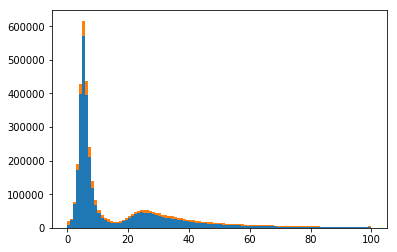

In [331]:
plt.hist([se.loc[se['prev_timingPoint'] == 0, 'dwell_duration_prev'], se.loc[se['prev_timingPoint'] == 1, 'dwell_duration_prev']], bins=100, stacked=True, range=(0,100));

In [365]:
# np.count_nonzero(np.isnan(se['median_durations_by_prev_stop_code_and_public_name_and_hour_and_daytype']))
se = se.dropna(subset=['median_durations_by_prev_stop_code_and_public_name_and_hour_and_daytype'])

In [371]:
print(f"MAPE median by code, hour, daytype, publicName: {MAPE(se['median_prev_dwell_by_segment_code_and_hour_and_daytype'], se['dwell_duration_prev'])}")
      

MAPE median by code, hour, daytype, publicName: 84.54449026864724


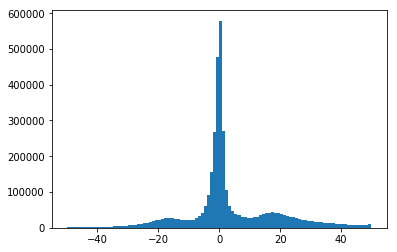

In [372]:
plt.hist(se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'], bins=100, range=(-50, 50));


In [373]:
np.mean(se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'])


6.700222720447034

In [374]:
np.std(se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'])


30.592716820478085

In [376]:
(se['median_prev_dwell_by_segment_code_and_hour_and_daytype'] - se['median_dwell_prev_durations_by_stop_code']).std()


36.94342218136824

## Looking at the bayesian esimates of some means and standard deviations travel times

In [11]:
stats.bayes_mvs(se['diff_segment_and_mediun_by_segment_code_and_hour_and_daytype'], alpha=0.9)

(Mean(statistic=6.519246219417394, minmax=(6.490571141811569, 6.54792129702322)),
 Variance(statistic=1190.4587730594515, minmax=(1189.059582778715, 1191.857963340188)),
 Std_dev(statistic=34.50302556384659, minmax=(34.48274922202046, 34.523301905672724)))

In [12]:
stats.bayes_mvs(se['median_durations_by_segment_code_and_hour_and_daytype'], alpha=0.9)

(Mean(statistic=39.51899909498335, minmax=(39.49646891067825, 39.54152927928845)),
 Variance(statistic=734.910825691202, minmax=(734.0470577827406, 735.7745935996635)),
 Std_dev(statistic=27.109238751599094, minmax=(27.093307505495577, 27.12516999770261)))

In [13]:
stats.bayes_mvs(se['segment_duration'], alpha=0.9)

(Mean(statistic=46.03824531440074, minmax=(46.000698393453874, 46.075792235347606)),
 Variance(statistic=2041.0507928807974, minmax=(2038.6518703002623, 2043.4497154613325)),
 Std_dev(statistic=45.17799013768538, minmax=(45.15144045527118, 45.204539820099576)))

In [14]:
(se['median_durations_by_segment_code_and_hour_and_daytype'] - se['median_durations_by_segment_code']).std()

9.884577531897612

In [381]:
(se['median_durations_by_segment_code_and_hour_and_daytype'] - se['median_dwell_prev_durations_by_stop_code']).abs().mean()


30.62373787917237

### Same with dwell times

In [378]:
stats.bayes_mvs(se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'], alpha=0.9)

(Mean(statistic=6.700222720447034, minmax=(6.674797336501881, 6.725648104392186)),
 Variance(statistic=935.914322483505, minmax=(934.8143025264181, 937.0143424405918)),
 Std_dev(statistic=30.59271682089554, minmax=(30.57473835949365, 30.610695282297428)))

In [379]:
stats.bayes_mvs(se['median_prev_dwell_by_segment_code_and_hour_and_daytype'], alpha=0.9)

(Mean(statistic=14.413174767131528, minmax=(14.400136413893037, 14.426213120370019)),
 Variance(statistic=246.11979204221217, minmax=(245.83051697014994, 246.4090671142744)),
 Std_dev(statistic=15.688205507393514, minmax=(15.678985999403071, 15.697425015383956)))

In [380]:
stats.bayes_mvs(se['dwell_duration_prev'], alpha=0.9)

(Mean(statistic=21.11339748757856, minmax=(21.085019517505543, 21.141775457651576)),
 Variance(statistic=1165.9064541199377, minmax=(1164.536114616825, 1167.2767936230505)),
 Std_dev(statistic=34.145372367568896, minmax=(34.12530611249396, 34.16543862264383)))

In [383]:
(se['median_prev_dwell_by_segment_code_and_hour_and_daytype'] - se['median_prev_dwell_by_segment_code']).std()

7.290213719226019

In [384]:
(se['median_prev_dwell_by_segment_code_and_hour_and_daytype'] - se['median_prev_dwell_by_segment_code']).abs().mean()

3.426111521570746

### Find the mean absolute difference and the standard devations of each pair of buses that do the same segment within 5 mins of each other.

In [16]:
se_segment_name_groups = se.groupby("segment_name")

In [17]:
differences = []
arrival_hours = []
weekend = []
dry = []
length = []
distance = []

for name, segment in se_segment_name_groups:
    
    segment = segment.sort_values("actualArrival")
    
    previous_bus = segment.shift(1)
    
    mask = (segment['actualArrival'] - previous_bus['actualArrival']) < pd.Timedelta("5 minute")
    
    differences.extend(segment[mask]['segment_duration'] - previous_bus[mask]['segment_duration'])
    
    arrival_hours.extend(segment[mask]['arrival_hour'])
    
    weekend.extend(segment[mask]['weekend'])
    
    dry.extend(segment[mask]['dry'])
    
    length.extend(segment[mask]['line_distance'])
    
    distance.extend(segment[mask]['to_centre_dist'])
    

In [18]:
differences = np.array(differences)
arrival_hours = np.array(arrival_hours)
weekend = np.array(weekend)
dry = np.array(dry)
length = np.array(length)
distance = np.array(distance)

In [19]:
length = len(differences)

print(length)

differences_filtered = np.sort(differences)[int(length/100):-int(length/100)]

print(len(differences_filtered))

1162208
1138964


In [20]:
stats.bayes_mvs(differences, alpha=0.9)

(Mean(statistic=-0.5940287797020843, minmax=(-0.6577734855331612, -0.5302840738710075)),
 Variance(statistic=1745.4909021800968, minmax=(1741.7245761318652, 1749.2572282283284)),
 Std_dev(statistic=41.77907253853413, minmax=(41.733998224776236, 41.824146852292024)))

In [21]:
stats.bayes_mvs(differences_filtered, alpha=0.9)

(Mean(statistic=-0.3783763139133458, minmax=(-0.41561192097219857, -0.3411407068544931)),
 Variance(statistic=583.6767053909387, minmax=(582.4044930124313, 584.948917769446)),
 Std_dev(statistic=24.159402008140404, minmax=(24.13307245788749, 24.185731558393318)))

In [22]:
np.mean(np.abs(differences))

18.614040688069604

In [23]:
np.median(np.abs(differences))

8.0

In [24]:
np.mean(np.abs(differences_filtered))

14.820170786785184

In [25]:
np.median(np.abs(differences_filtered))

7.0

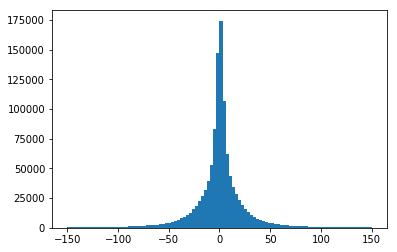

In [26]:
plt.hist(differences, bins=100, range=(-150, 150));

## Approach one, subtract the mean for each segment/hour/daytype

Try using both the mean and the median

In [27]:
mean_durations_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["segment_duration"]
    .mean()
    .rename("mean_durations_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    mean_durations_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [295]:
just_noise = se['segment_duration'] - se['median_durations_by_segment_code_and_hour_and_daytype']

In [296]:
min_p, max_p = np.percentile(just_noise, [0.01,99.99])
just_noise_2_in_10000 = just_noise[(just_noise < max_p) & (just_noise > min_p)]

In [340]:
# From: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
# And then improved...

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True, range=(-100, 100))
    x = (x + np.roll(x, -1))[:-1] / 2.0
 
    dist_continu = [d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_continuous)]
#     dist_continu = ["cauchy", "johnsonsu", "tukeylambda", "norminvgauss", "t"] 

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    
    dist_results_name = []
    dist_results_p = []
    dist_results_D = []
    dist_results_sse = []
    dist_results_chi2_score = []
    dist_results_chi2_p = []
    params = {}

    # Estimate distribution parameters from data
    for dist_name in dist_continu:
        
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                dist = getattr(stats, dist_name)
                param = dist.fit(data)
                
                params[dist_name] = param
                D, p = stats.kstest(data, dist_name, args=param)

                # Separate parts of parameters
                arg = param[:-2]
                loc = param[-2]
                scale = param[-1]
                
                print(".", end="", flush=True)

                # Calculate fitted PDF and error with fit in distribution
                pdf = dist.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                chi2 = stats.chisquare(y, pdf)
                
                dist_results_name.append(dist_name)
                dist_results_p.append(p)
                dist_results_D.append(D)
                dist_results_sse.append(sse)
                dist_results_chi2_score.append(chi2[0])
                dist_results_chi2_p.append(chi2[1])
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = dist_name
                    best_params = param
                    best_sse = sse

        except Exception:
            pass
        
    sorted_idx = np.argsort(dist_results_sse)
    
    print("\nResults")
    for i in range(len(sorted_idx)):
        print(f"{dist_results_name[sorted_idx[i]]: <14},sse:{dist_results_sse[sorted_idx[i]]:0.6f} chi2:{dist_results_chi2_score[sorted_idx[i]]:0.6f} chi1_p:{dist_results_chi2_p[sorted_idx[i]]:0.6f} p:{dist_results_p[sorted_idx[i]]:0.4f} D:{dist_results_D[sorted_idx[i]]:0.4f}")
        

    return (best_distribution, best_params)

.................................................................................................
Results
gennorm       ,sse:0.004724 chi2:0.309691 chi1_p:1.000000 p:0.0000 D:0.1351
t             ,sse:0.006084 chi2:0.556275 chi1_p:1.000000 p:0.0000 D:0.1455
johnsonsu     ,sse:0.006630 chi2:0.319676 chi1_p:1.000000 p:0.0000 D:0.0843
nct           ,sse:0.007967 chi2:0.422601 chi1_p:1.000000 p:0.0000 D:0.0937
dweibull      ,sse:0.010400 chi2:0.295870 chi1_p:1.000000 p:0.0000 D:0.1406
cauchy        ,sse:0.012794 chi2:0.635870 chi1_p:1.000000 p:0.0000 D:0.1560
norminvgauss  ,sse:0.014339 chi2:0.483246 chi1_p:1.000000 p:0.0000 D:0.1205
tukeylambda   ,sse:0.014819 chi2:0.839085 chi1_p:1.000000 p:0.0000 D:0.1739
dgamma        ,sse:0.016156 chi2:0.525603 chi1_p:1.000000 p:0.0000 D:0.2028
laplace       ,sse:0.026198 chi2:0.942975 chi1_p:1.000000 p:0.0000 D:0.2126
hypsecant     ,sse:0.031944 chi2:1.413321 chi1_p:1.000000 p:0.0000 D:0.1745
genlogistic   ,sse:0.032943 chi2:2.358420 chi1_p:1.000000 

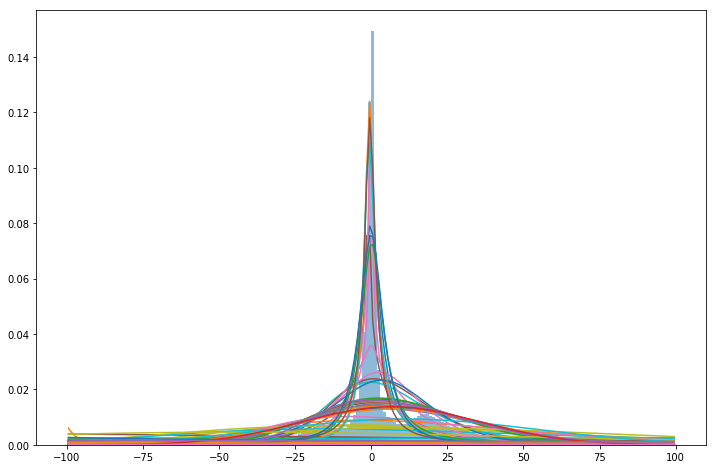

(0.3744386408189616, -9.141857720397791e-20, 0.40193944799129655)


In [341]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.hist(se['diff_prev_dwell_and_mediun_by_segment_code_and_hour_and_daytype'], bins=200, density=True, alpha=0.5, range=(-100, 100))
# Save plot limits
dataYLim = ax.get_ylim()

one_percent_data = np.random.choice(se['diff_prev_dwell_and_mediun_by_segment_code_and_hour_and_daytype'], int(se.shape[0]/100), replace=False)

st = stats
best_dist, best_params = best_fit_distribution(one_percent_data, 200, ax)

ax.set_ylim(dataYLim);

plt.show()

print(best_params)

In [310]:
stats.cauchy.fit(just_noise)

(0.9775821290798283, -0.3946359644175342, 4.686630878944959)

In [307]:
best_params

(-0.30933567903934067,
 0.5603583009365332,
 -1.548913931561055,
 2.9268979929733177)

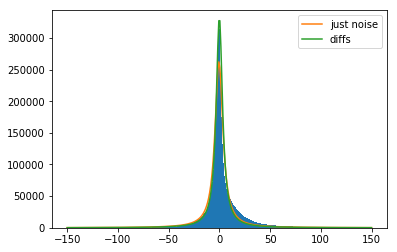

In [300]:
fig, ax1 = plt.subplots()

granularity = 300

ax1.hist(just_noise, bins=granularity, range=(-150, 150));

# ax2 = ax1.twinx()
x = np.linspace(-150, 150, granularity)
ax1.plot(x, stats.cauchy.pdf(x, -0.3848045122209864, 4.753788866524921) * len(just_noise), label="just noise")
ax1.plot(x, stats.cauchy.pdf(x, 0, 7.488655070821551/2) * len(just_noise), label="diffs")
ax1.legend()

((array([-11679837.34899335,  -4714931.97611849,  -2925803.35328832, ...,
           2925802.56378817,   4714931.18687263,  11679836.55972142]),
  array([-3583. , -2265. , -1815. , ...,  2853.5,  3541. ,  3553.5])),
 (0.0005999621015737456, 6.519482986040019, 0.16918992439742))

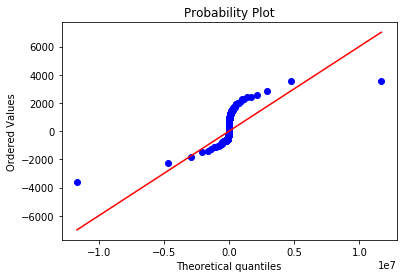

In [311]:
stats.probplot(just_noise, sparams=(-0.3848045122209864, 4.753788866524921), dist="cauchy", plot=plt)

In [196]:
stats.cauchy.fit(differences)

(0.07997091972321868, 7.488655070821551)

In [200]:
rv = stats.cauchy(loc=0, scale=7.488655070821551/2)

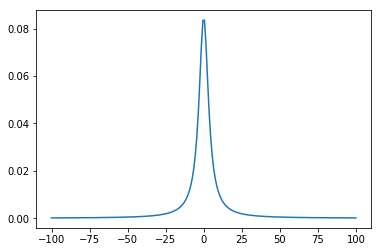

In [266]:
min_p, max_p = np.percentile(just_noise, [0.1,99.9])

x = np.linspace(-100,100, 200)
plt.plot(x, np.clip(rv.pdf(x), min_p, max_p))

## Analytic Noise Standard Deviation using distribution found from differences

In [377]:
min_p, max_p = np.percentile(just_noise, [0.1,99.9])

samples = stats.cauchy.rvs(loc=0, scale=7.488655070821551/2, size=100000000)

samples_truncated = samples[(samples > min_p) & (samples < max_p)]

np.std(samples_truncated)

22.796971394987445

In [339]:
len(samples_truncated)/len(samples)

0.98324377

## Analytic Noise Standard Deviation using Just Noise

In [301]:
np.std(just_noise)

34.50302556417721

In [302]:
np.std(just_noise_2_in_10000)

32.31197290694672

In [393]:
se.memory_usage().sort_values()

train                                                                     3917018
test                                                                      3917018
Index                                                                    31336144
diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day    31336144
diff_percent_full_segment_and_median_by_segment_code                     31336144
diff_full_segment_and_median_by_segment_code_and_hour_and_day            31336144
diff_full_segment_and_median_by_segment_code                             31336144
median_full_durations_by_segment_code_and_hour_and_day                   31336144
median_full_durations_by_segment_code_and_hour                           31336144
diff_segment_and_median_by_segment_code                                  31336144
median_full_durations_by_segment_code                                    31336144
median_dwell_dest_by_stop_code_and_hour_and_day                          31336144
median_dwell_pre

In [386]:
def exclude_columns_containing(se, to_remove):

    min_cols = [c for c in se.columns if not any(x in c for x in to_remove)]

    se_min = se[min_cols]

    return se_min


In [387]:
se = exclude_columns_containing(se, ["prev_segment_code_",
            "next_segment_code_",
            "prev_event_index_",
            "next_event_index_",
            "offset_timestamp_5_"])

se = exclude_columns_containing(se, ["prev_stop_", "next_stop_", "road"])

In [388]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('se', 4854970495),
 ('samples', 800000096),
 ('samples_truncated', 786615496),
 ('just_noise', 62672904),
 ('scaled_durations', 62672904),
 ('just_noise_2_in_10000', 62660232),
 ('scaled_durations_2_in_10000', 62614600),
 ('arrival_hours', 9297760),
 ('differences', 9297760),
 ('distance', 9297760),
 ('previous_bus', 1719446),
 ('segment', 1687449),
 ('dry', 1162304),
 ('weekend', 1162304),
 ('median_durations_by_prev_stop_code_and_public_name_and_hour_and_daytype',
  678052),
 ('mean_durations_by_segment_code_and_hour_and_daytype', 431394),
 ('one_percent_data', 313456),
 ('median_prev_dwell_by_segment_code', 93680),
 ('mask', 4533),
 ('dist_continu', 912),
 ('MAPE', 136),
 ('best_fit_distribution', 136),
 ('exclude_columns_containing', 136),
 ('filter_rare', 136),
 ('get_best_distribution', 136),
 ('make_prediction', 136),
 ('mean_absolute_error', 136),
 ('mean_squared_error', 136),
 ('differences_filtered', 96),
 ('x', 96),
 ('colors', 80),
 ('ma', 80),
 ('np', 80),
 ('pd', 80),
 

In [389]:
13149250104 - 4854970495

8294279609